In [29]:
!pip install wbdata

In [30]:
import wbdata
import pandas as pd
import datetime

# Set the date range
start_date = datetime.datetime(2000, 1, 1)
end_date = datetime.datetime(2020, 1, 1)

# Define the indicators (including approximations for vehicles per capita, energy mix, and EV adoption)
indicators = {
    'EN.ATM.CO2E.KT': 'CO2_emissions',
    'NY.GDP.MKTP.CD': 'GDP_current_US',
    'SP.POP.TOTL': 'Population_total',
    'EG.USE.PCAP.KG.OE': 'Energy_use_kg_of_oil_equivalent_per_capita',
    'SP.URB.TOTL.IN.ZS': 'Urban_population_percentage_of_total',
    'SE.TER.CUAT.BA.ZS': "Educational_attainment_at_least_Bachelors_or_equivalent_population_25_older_than_total_percentage",
    'IS.VEH.NVEH.P3': 'Passenger_cars_per_1000_people',
    'EG.ELC.RNEW.ZS': 'Renewable_electricity_output_percentage_of_total',
}

# Get data for all countries
data = wbdata.get_dataframe(indicators, date=(start_date, end_date))

# Display the first few rows
print(data.head())

# Optionally, save the data to a CSV file
data.to_csv('world_bank_extended_data.csv')


                  CO2_emissions  GDP_current_US  Population_total  \
country     date                                                    
Afghanistan 2000       1078.120    3.521418e+09        19542982.0   
            2001       1088.638    2.813572e+09        19688632.0   
            2002       1403.030    3.825701e+09        21000256.0   
            2003       1653.207    4.520947e+09        22645130.0   
            2004       1292.307    5.224897e+09        23553551.0   

                  Energy_use_kg_of_oil_equivalent_per_capita  \
country     date                                               
Afghanistan 2000                                         NaN   
            2001                                         NaN   
            2002                                         NaN   
            2003                                         NaN   
            2004                                         NaN   

                  Urban_population_percentage_of_total  \
country  

In [31]:
# Reset the index to make 'country' and 'date' columns
data_transformed = data.reset_index()

# Display the first few rows of the transformed DataFrame
print(data_transformed.head())


       country  date  CO2_emissions  GDP_current_US  Population_total  \
0  Afghanistan  2000       1078.120    3.521418e+09        19542982.0   
1  Afghanistan  2001       1088.638    2.813572e+09        19688632.0   
2  Afghanistan  2002       1403.030    3.825701e+09        21000256.0   
3  Afghanistan  2003       1653.207    4.520947e+09        22645130.0   
4  Afghanistan  2004       1292.307    5.224897e+09        23553551.0   

   Energy_use_kg_of_oil_equivalent_per_capita  \
0                                         NaN   
1                                         NaN   
2                                         NaN   
3                                         NaN   
4                                         NaN   

   Urban_population_percentage_of_total  \
0                                22.078   
1                                22.169   
2                                22.261   
3                                22.353   
4                                22.500   

   Educ

In [32]:
print(data_transformed.isnull().sum())


country                                                                                                 0
date                                                                                                    0
CO2_emissions                                                                                         671
GDP_current_US                                                                                        289
Population_total                                                                                      125
Energy_use_kg_of_oil_equivalent_per_capita                                                           2763
Urban_population_percentage_of_total                                                                  167
Educational_attainment_at_least_Bachelors_or_equivalent_population_25_older_than_total_percentage    4408
Passenger_cars_per_1000_people                                                                       5527
Renewable_electricity_output_percentage_of_tot

In [36]:
from sklearn.impute import KNNImputer
from sklearn.preprocessing import StandardScaler


df_numeric = data_transformed.drop(columns=['country', 'date'])

# Standardize the data
scaler = StandardScaler()
df_numeric_scaled = scaler.fit_transform(df_numeric)

# Apply KNN Imputation on the standardized data
imputer = KNNImputer(n_neighbors=3)
df_imputed_scaled = imputer.fit_transform(df_numeric_scaled)

# Inverse transform to return to the original scale
df_imputed = scaler.inverse_transform(df_imputed_scaled)

# Convert the imputed array back to a DataFrame
df_imputed = pd.DataFrame(df_imputed, columns=df_numeric.columns)

# Combine with the non-numeric columns
df_imputed_full = pd.concat([data_transformed[['country', 'date']], df_imputed], axis=1)

In [37]:
print(df_imputed_full.describe())

       CO2_emissions  GDP_current_US  Population_total  \
count   5.690000e+03    5.690000e+03      5.690000e+03   
mean    1.030626e+06    1.908900e+12      2.793706e+08   
std     3.476438e+06    7.095445e+12      8.705055e+08   
min     0.000000e+00    1.396473e+07      9.609000e+03   
25%     2.303333e+03    5.644204e+09      1.652923e+06   
50%     2.011651e+04    3.449635e+10      9.947042e+06   
75%     2.373627e+05    4.338546e+11      6.780651e+07   
max     3.556056e+07    8.794557e+13      7.821272e+09   

       Energy_use_kg_of_oil_equivalent_per_capita  \
count                                 5690.000000   
mean                                  2093.043120   
std                                   2482.653514   
min                                      9.579196   
25%                                    607.012896   
50%                                   1234.844683   
75%                                   2483.822436   
max                                  21420.628504   


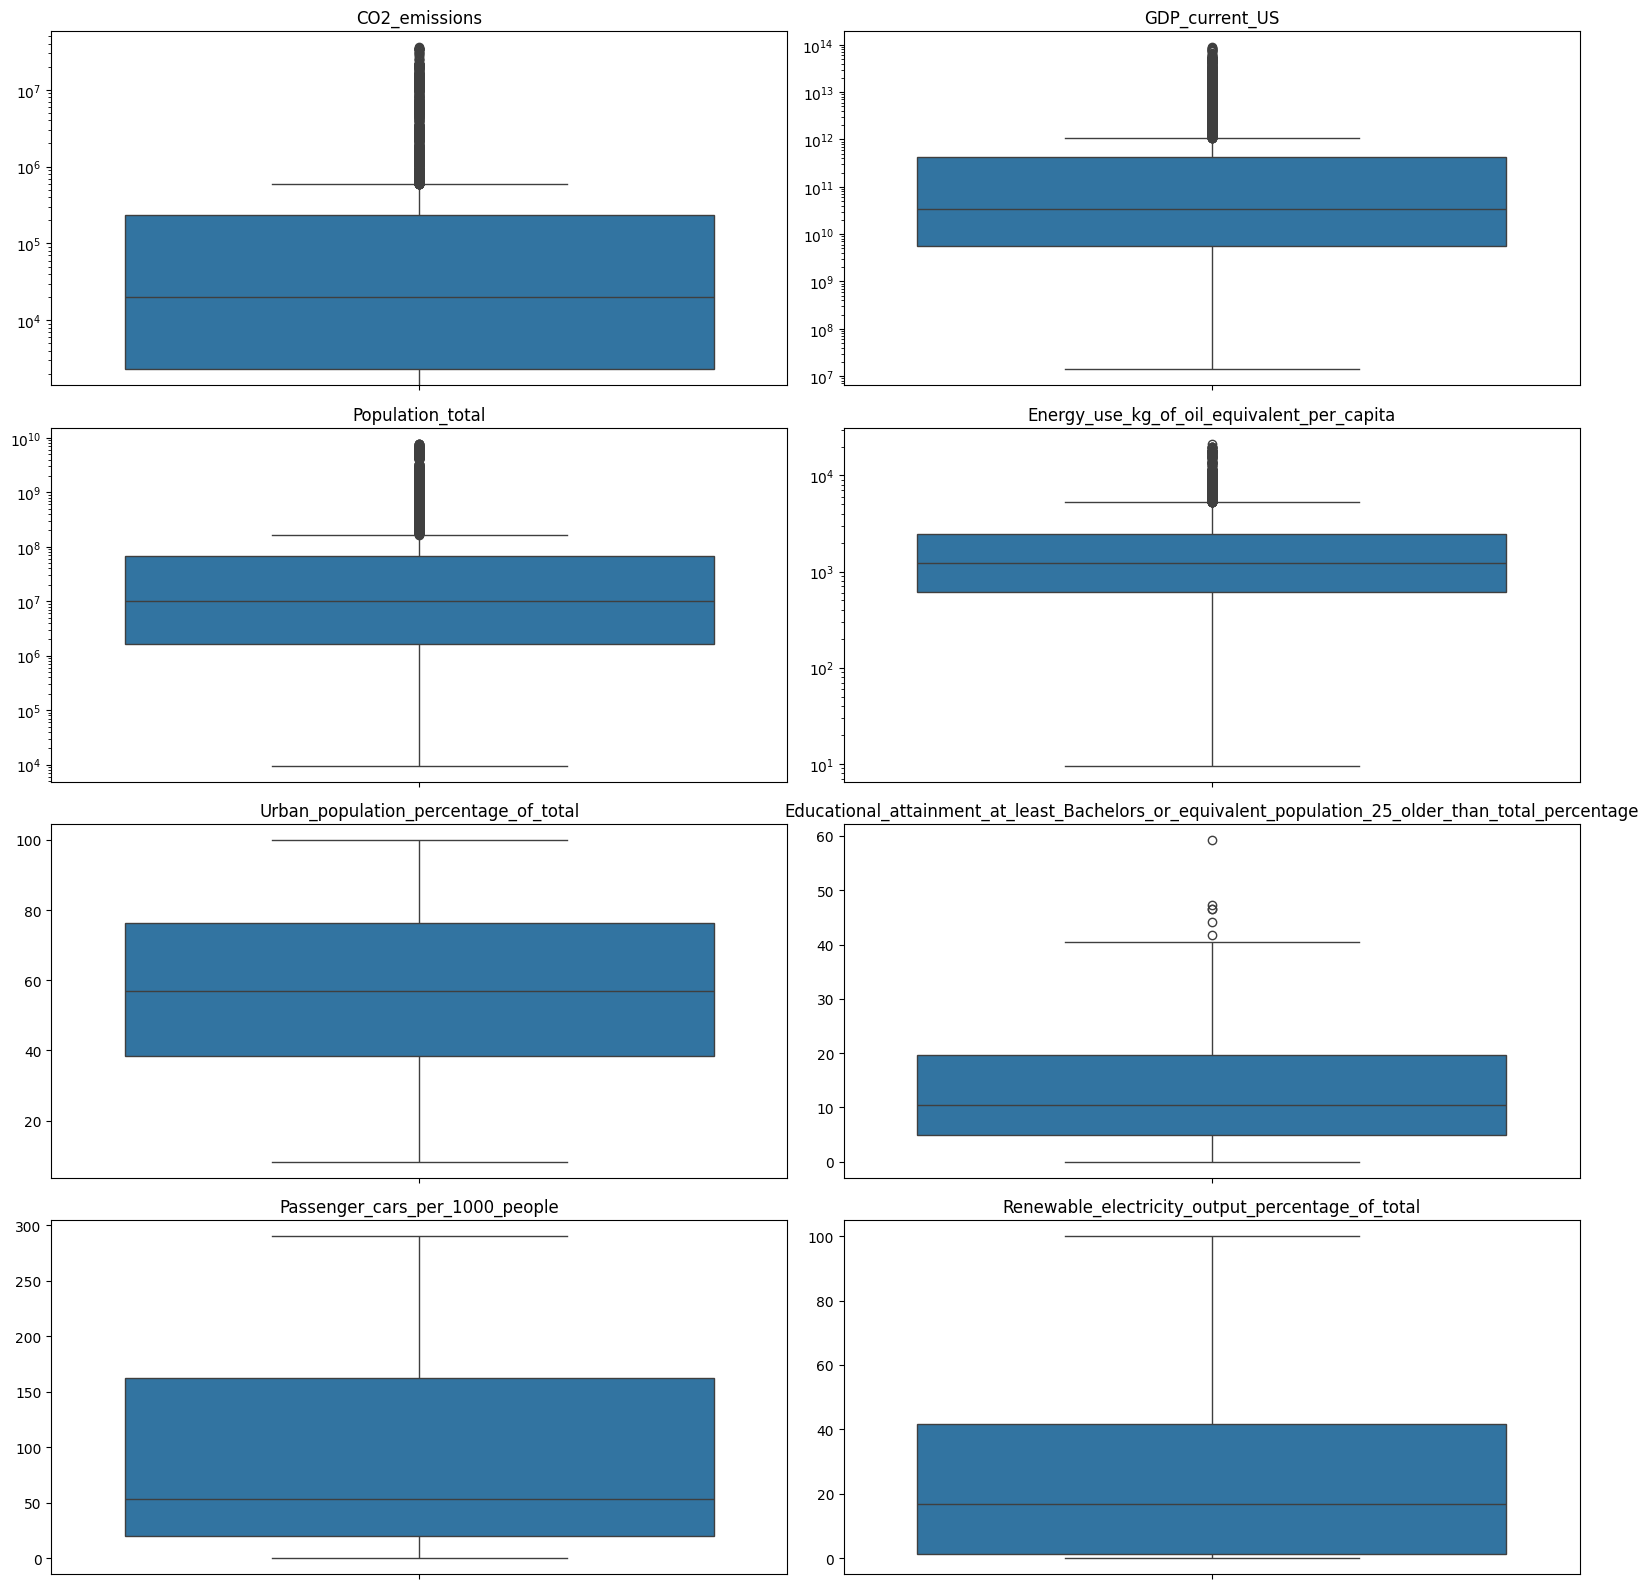

In [51]:
import matplotlib.pyplot as plt
import seaborn as sns

# Create a 4x2 grid of subplots
fig, axes = plt.subplots(4, 2, figsize=(16, 16))

# Flatten the axes array for easier iteration
axes = axes.flatten()

# Iterate over the columns and create boxplots
for i, col in enumerate(df_imputed_full.columns[2:]):  # Start from index 2 to exclude 'country' and 'date'
    ax = axes[i]
    sns.boxplot(y=df_imputed_full[col], ax=ax)
    ax.set_title(col)
    ax.set_ylabel('')  # Remove y-axis label for cleaner look

    # Apply log scale to the first four plots
    if i < 4:
        ax.set_yscale('log')

# Adjust layout to prevent legend overlap
plt.tight_layout()
plt.show()


In [50]:
# Calculate outlier percentages for each column
outlier_percentages = {}
for col in df_imputed_full.columns[2:]:  # Start from index 2 to exclude 'country' and 'date'
    Q1 = df_imputed_full[col].quantile(0.25)
    Q3 = df_imputed_full[col].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    outliers = df_imputed_full[(df_imputed_full[col] < lower_bound) | (df_imputed_full[col] > upper_bound)]
    outlier_percentage = (len(outliers) / len(df_imputed_full)) * 100
    outlier_percentages[col] = round(outlier_percentage, 2)

# Print the outlier percentages
for col, percentage in outlier_percentages.items():
    print(f"Outlier percentage for {col}: {percentage:.2f}%")


Outlier percentage for CO2_emissions: 17.47%
Outlier percentage for GDP_current_US: 18.58%
Outlier percentage for Population_total: 20.09%
Outlier percentage for Energy_use_kg_of_oil_equivalent_per_capita: 9.35%
Outlier percentage for Urban_population_percentage_of_total: 0.00%
Outlier percentage for Educational_attainment_at_least_Bachelors_or_equivalent_population_25_older_than_total_percentage: 0.11%
Outlier percentage for Passenger_cars_per_1000_people: 0.00%
Outlier percentage for Renewable_electricity_output_percentage_of_total: 0.00%


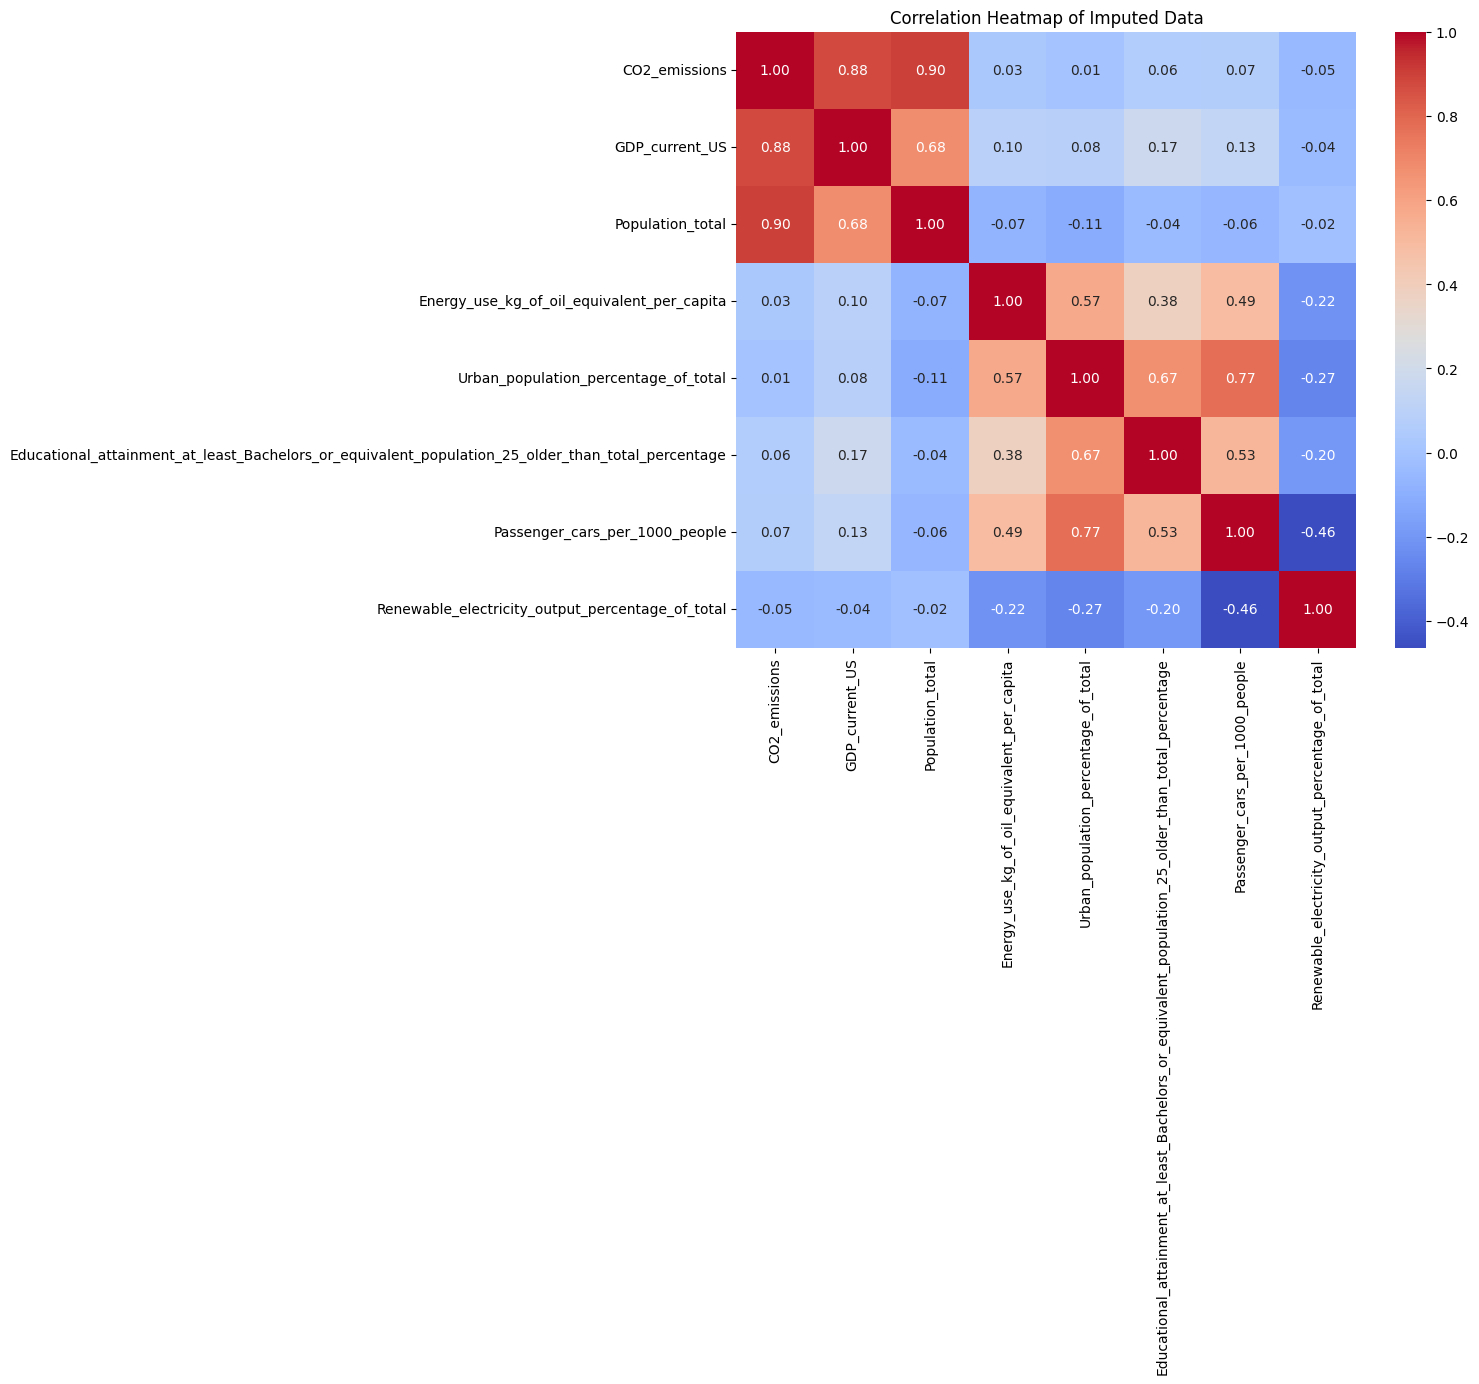

In [39]:
import seaborn as sns
import matplotlib.pyplot as plt

# Calculate the correlation matrix
corr_matrix = df_imputed.corr()

# Create a heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Heatmap of Imputed Data')
plt.show()


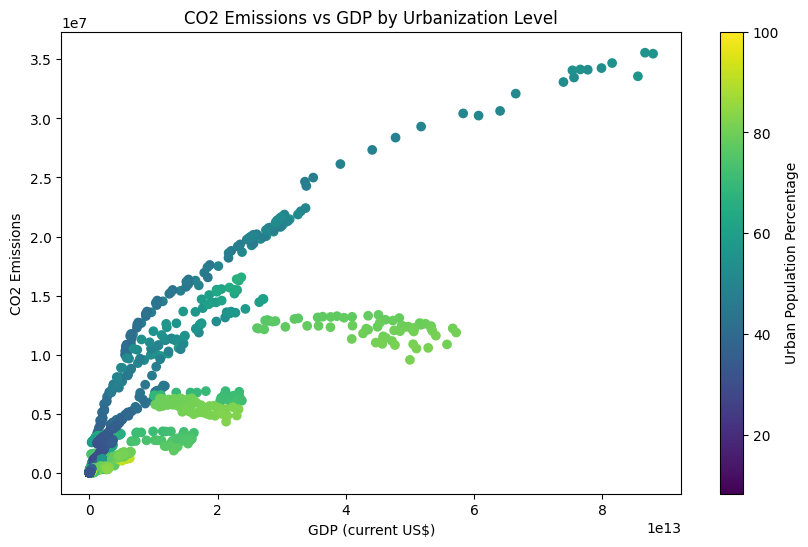

In [41]:
# @title CO2 Emissions vs GDP by Urbanization Level

import matplotlib.pyplot as plt
plt.figure(figsize=(10, 6))
plt.scatter(df_imputed['GDP_current_US'], df_imputed['CO2_emissions'], c=df_imputed['Urban_population_percentage_of_total'], cmap='viridis')
plt.xlabel('GDP (current US$)')
plt.ylabel('CO2 Emissions')
plt.title('CO2 Emissions vs GDP by Urbanization Level')
_ = plt.colorbar(label='Urban Population Percentage')


In [52]:
df_imputed_full.head()

,country,date,CO2_emissions,GDP_current_US,Population_total,Energy_use_kg_of_oil_equivalent_per_capita,Urban_population_percentage_of_total,Educational_attainment_at_least_Bachelors_or_equivalent_population_25_older_than_total_percentage,Passenger_cars_per_1000_people,Renewable_electricity_output_percentage_of_total
0,Afghanistan,2000,1078.120,3.521418e+09,19542982.0,450.578201,22.078,4.036244,18.333333,74.989094
1,Afghanistan,2001,1088.638,2.813572e+09,19688632.0,446.229227,22.169,4.036244,18.333333,72.811460
2,Afghanistan,2002,1403.030,3.825701e+09,21000256.0,466.081702,22.261,4.036244,13.333333,79.063971
3,Afghanistan,2003,1653.207,4.520947e+09,22645130.0,448.841374,22.353,4.036244,18.900000,70.249729
4,Afghanistan,2004,1292.307,5.224897e+09,23553551.0,448.841374,22.500,4.036244,18.900000,70.890841


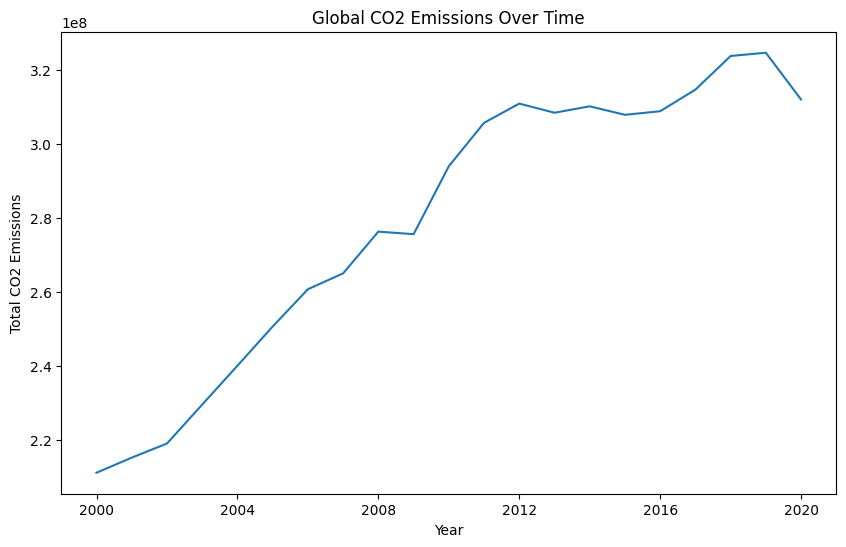

In [60]:

import seaborn as sns
import matplotlib.pyplot as plt

# Assuming 'date' is a string and needs to be converted to datetime
df_imputed_full['date'] = pd.to_datetime(df_imputed_full['date'], format='%Y')

# Group by date and sum CO2 emissions for each year
co2_by_date = df_imputed_full.groupby('date')['CO2_emissions'].sum().reset_index()

# Create the lineplot
plt.figure(figsize=(10, 6))
sns.lineplot(x='date', y='CO2_emissions', data=co2_by_date)
plt.xlabel('Year')
plt.ylabel('Total CO2 Emissions')
plt.title('Global CO2 Emissions Over Time')
plt.show()


In [42]:
df_imputed_full.to_csv('world_bank_extended_data_imputed.csv', index=False)